Berner Fachhochschule BFH - MAS Data Science - Graph Machine Learning - Master Thesis FS/2022 Thomas Iten

# 12. GCN Link Prediction

**Inhalt**
1. Cora Datenset laden inklusive Features
2. Test- und Trainingsdaten aufbereiten
3. Link Generator definieren
4. GCN Model erstellen
5. Test Performance mit untrainiertem Model
6. Model trainieren
7. Test Performance

**Referenzen**<br />
[1] https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html


In [1]:
import stellargraph as sg
from stellargraph import datasets
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

from tensorflow import keras

from IPython.display import display, HTML

## 12.1 Cora Datenset laden inklusive Features
Laden der Cora Daten direkt mit Hilfe der Datasets Klasse. Jeder Node repräsentiert ein Schreiben. Mit dem Parameter subject_as_feature True wird das Thema (Subject) direkt als Node Feature mitgeliefert.

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
graph, _ = dataset.load(subject_as_feature=True)

print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


## 12.2 Test- und Trainigsdaten aufbereiten
Für die Aufteilung der Daten wird die Klasse EdgeSplitter aus dem stellargraph.data Package verwendent.

**Testdaten**

Als erstes werden aus dem gesammten Graphen einen Teilgraphen sowie eine Liste von Verbindungen und Labels für die Tests generiert.
- test_graph   : Subset von original Graphen mit allen Knoten aber nur einem Teil der Verbindungen
- test_samples : Liste mit Knotenpaaren mit realen Verbindungen (positive edges) und Knotenpaaren die keine Verbindungen haben (negative edges)
- test_labels  : Liste mit den Labeln passend zu den Knotenpaaren der Testdaten

In [3]:
edgeSplitter = EdgeSplitter(graph)
test_graph, test_samples, test_labels  = edgeSplitter.train_test_split(p=0.1, method="global", keep_connected=True)

** Sampled 542 positive and 542 negative edges. **


**Trainingsdaten**

Das gleich wird anschliessend für die Trainingsdaten gemacht. Bei der Initialisierung der EdgeSplitter Klassen wird zusätzlich der erstellte test_graph übergeben, so dass die Trainings- und Testdaten nicht überschneiden.

In [4]:
edgeSplitter = EdgeSplitter(test_graph)
train_graph, train_samples, train_labels = edgeSplitter.train_test_split(p=0.1, method="global", keep_connected=True)

** Sampled 488 positive and 488 negative edges. **


## 12.3 Link Generator definieren
Mit Hilfe des FullBatchLinkGenerator wird für die Trainigs- und Testdaten je ein Flow Objekt erzeugt. Diese liefert die Knoten Paarweise zusammen mit dem entsprechenden Label. Mit Hilfe vom Flow Objekt wird anschliessend das Model Training durchgeführt, sowie die Performance gemessen. Mit der Angabe method="gcn" wird die Adjazenzmatrix für den GCN Algorithmus normalisiert.

In [5]:
train_gen  = FullBatchLinkGenerator(train_graph, method="gcn")
train_flow = train_gen.flow(train_samples, train_labels)

test_gen   = FullBatchLinkGenerator(test_graph, method="gcn")
test_flow  = test_gen.flow(test_samples, test_labels)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


## 12.4 GCN Model erstellen
Das GCN Modell wird wie folgt aufgebaut:
- layer_sizes: Anzahl "hidden features" pro Layer. Hier werden zwei 16-dimensionale GCN Layer definiert.
- activations: Definition der Aktivierungen pro Layer. Hier werden zwei Relu für die beiden Layer definiert.
- dropout: Mit der Angabe dropout=0.3 werden 30% dropout für jeden Layer spezifiziert.

Die Knoten Embeddings des GCN Modell werden nun mit einer Link Klassifizierungschicht verknüpft. Die Edge Embedding Methode 'ip' steht für Inner Product (es sind auch noch andere wie Hadamard, L1, L2 oder Avg möglich). Damit wird schliesslich ein vollständiges Keras Model mit einen Adam Optimierer erzeugt. Als Loss Funktion wird binäre Kreuzentropi (binary crossentropy) eingesetzt.

In [6]:
gcn = GCN(
    layer_sizes=[16, 16],
    activations=["relu", "relu"],
    generator=train_gen,
    dropout=0.3
)

x_inp, x_out = gcn.in_out_tensors()
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)

model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

# 12.5 Test Performance mit untrainiertem Model

In [11]:
def evaluate_metrics(title, metric_names, metrics):
    print()
    print(title)
    for name, val in zip(metric_names, metrics):
        print("- {}: {:0.4f}".format(name, val))

train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

evaluate_metrics("Untrained Performance Training Set:", model.metrics_names, train_metrics)
evaluate_metrics("Untrained Performance Test Set:", model.metrics_names, test_metrics)

1/1 [==============================] - 0s 79ms/step - loss: 0.6091 - binary_accuracy: 0.7011

Untrained Performance Training Set:
- loss: 0.5199
- binary_accuracy: 0.7654

Untrained Performance Test Set:
- loss: 0.6091
- binary_accuracy: 0.7011


## 12.6 Model trainieren

In [8]:
epochs = 60
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, shuffle=False)

Epoch 1/60
1/1 [==============================] - 1s 980ms/step - loss: 1.7964 - binary_accuracy: 0.5000 - val_loss: 1.6103 - val_binary_accuracy: 0.5000
Epoch 2/60
1/1 [==============================] - 0s 136ms/step - loss: 1.5826 - binary_accuracy: 0.5010 - val_loss: 1.3831 - val_binary_accuracy: 0.5000
Epoch 3/60
1/1 [==============================] - 0s 195ms/step - loss: 1.3678 - binary_accuracy: 0.5051 - val_loss: 1.1836 - val_binary_accuracy: 0.5018
Epoch 4/60
1/1 [==============================] - 0s 196ms/step - loss: 1.1882 - binary_accuracy: 0.5061 - val_loss: 1.0129 - val_binary_accuracy: 0.5120
Epoch 5/60
1/1 [==============================] - 0s 181ms/step - loss: 1.0024 - binary_accuracy: 0.5123 - val_loss: 0.8713 - val_binary_accuracy: 0.5314
Epoch 6/60
1/1 [==============================] - 0s 140ms/step - loss: 0.9181 - binary_accuracy: 0.5297 - val_loss: 0.7596 - val_binary_accuracy: 0.5821
Epoch 7/60
1/1 [==============================] - 0s 161ms/step - loss: 0.80

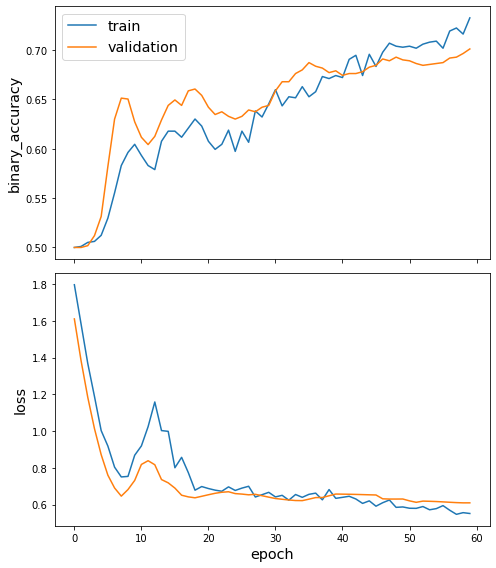

In [9]:
sg.utils.plot_history(history)

## 12.7 Test Performance
Nun kann das trainierte Modell für die Vorhersagen genutzt werden. Dazu messen wir die Performance der Trainings- und Testdaten.

In [10]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

evaluate_metrics("Performance Training Set:", model.metrics_names, train_metrics)
evaluate_metrics("Performance Test Set:", model.metrics_names, test_metrics)

1/1 [==============================] - 0s 80ms/step - loss: 0.6091 - binary_accuracy: 0.7011

Performance Training Set:
- loss: 0.5199
- binary_accuracy: 0.7654

Performance Test Set:
- loss: 0.6091
- binary_accuracy: 0.7011


---
_The end._